In [1]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.dpi'] = 120

from shmex.local import localify
from shmex.shm_zoo import long_name_of_short_name, fix_parameter_count
figures_dir = localify('FIGURES_DIR')

# default_font_size = plt.rcParams['font.size']
# plt.rcParams.update({'font.size': default_font_size * 1.4})

Using Metal Performance Shaders


In [2]:
# compare_df = pd.read_csv("../train/_ignore/mouse_model_compare.csv")
compare_df = pd.read_csv("../train/_ignore/human_model_compare.csv")
#compare_df = pd.read_csv("../train/_ignore/prod_model_compare.csv")

# drop rows where crepe_basename is s5f and put them in a separate df called fixed_df
literature_models = ["s5f","cnn_ind_med-shmoof_small"]
fixed_df = compare_df[compare_df["crepe_basename"].isin(literature_models)]
compare_df = compare_df[~compare_df["crepe_basename"].isin(literature_models)]

# split crepe_basename on "-", the first entry is the model name and the second entry is the train dataset
compare_df["model"] = compare_df["crepe_basename"].apply(lambda x: x.split("-")[0])
compare_df["train dataset"] = compare_df["crepe_basename"].apply(lambda x: x.split("-")[1])
compare_df["training method"] = compare_df["crepe_basename"].apply(lambda x: x.split("-")[2])
compare_df["seed"] = compare_df["crepe_basename"].apply(lambda x: x.split("-")[3])
compare_df = compare_df.drop(columns=["crepe_prefix", "crepe_basename"])
compare_df = compare_df.rename(columns={"dataset_name": "test dataset"})
compare_df = compare_df.sort_values(by=["train dataset", "model"]).reset_index(drop=True)

compare_df["model"].unique()
compare_df

,parameter_count,test dataset,AUROC,AUPRC,r-prec,mut_pos_ll,sub_acc,base_ll,overlap,residual,model,train dataset,training method,seed
0,5931,shmoof_notbig_all,0.799328,0.106871,0.053046,-0.063502,0.563883,-0.943803,0.939794,0.016914,cnn_ind_lrg,shmoof_notbig,simple,0
1,5931,val_tangshm_all,0.822907,0.198197,0.127523,-0.144820,0.477814,-1.049025,0.973705,0.008154,cnn_ind_lrg,shmoof_notbig,simple,0
2,5931,shmoof_notbig_all,0.798892,0.107046,0.053390,-0.063553,0.563962,-0.945143,0.937598,0.018092,cnn_ind_lrg,shmoof_notbig,simple,1
3,5931,val_tangshm_all,0.821840,0.196587,0.127499,-0.145535,0.480146,-1.049591,0.975235,0.007675,cnn_ind_lrg,shmoof_notbig,simple,1
4,5931,shmoof_notbig_all,0.798391,0.106805,0.052667,-0.063561,0.565408,-0.946445,0.937580,0.017937,cnn_ind_lrg,shmoof_notbig,simple,2
5,5931,val_tangshm_all,0.821650,0.197584,0.129027,-0.144782,0.477633,-1.052594,0.980044,0.006257,cnn_ind_lrg,shmoof_notbig,simple,2
6,4539,shmoof_notbig_all,0.797838,0.106294,0.052259,-0.063667,0.563225,-0.947995,0.939429,0.017540,cnn_ind_med,shmoof_notbig,simple,0
7,4539,val_tangshm_all,0.822907,0.196938,0.126712,-0.145195,0.479965,-1.054502,0.971117,0.008528,cnn_ind_med,shmoof_notbig,simple,0
8,4539,shmoof_notbig_all,0.797903,0.105144,0.051741,-0.063693,0.563251,-0.947910,0.941457,0.016697,cnn_ind_med,shmoof_notbig,simple,1
9,4539,val_tangshm_all,0.822553,0.197789,0.129051,-0.145352,0.479402,-1.052432,0.969585,0.009386,cnn_ind_med,shmoof_notbig,simple,1


In [3]:
df = compare_df.copy()

# drop any rows where model matches 4k or 8k
df = df[~df.model.str.contains("4k")]
df = df[~df.model.str.contains("8k")]

# NOTE restrictions here
#df = df[df["train dataset"] == "shmoof_small"]
df = df[df["test dataset"].str.endswith("_all")]


df["parameter_count"] = df.apply(fix_parameter_count, axis=1)

def create_long_name(row):
    full_name = long_name_of_short_name(row["model"])
    return f"{full_name} ({row['parameter_count']}) {row['training method']}"

# Apply the transformation to create the long_name column
df['long_name'] = df.apply(create_long_name, axis=1)

# sort df by parameter count
df = df.sort_values(by="parameter_count", kind="mergesort")
# reverse stable sort by test dataset   
df = df.sort_values(by="test dataset", kind="mergesort")

# extract the rows where "test dataset" is "val_oracleshmoofcnn10k" and put them in a separate df called oracle_df
for (oracle_data, oracle_data_nickname) in [("val_oracleshmoofcnn10k", "shmoof_small"), ("val_oracletangcnn", "val_tangshm")]:
    oracle_df = df[df["test dataset"] == oracle_data]
    df = df[df["test dataset"] != oracle_data]

    # drop all rows where model isn't cnn_joi_lrg
    oracle_df = oracle_df[oracle_df["model"] == "cnn_joi_lrg"]
    oracle_df["test dataset"] = oracle_data_nickname
    oracle_df["long_name"] = "Oracle"

    # append oracle_df to df
    df = pd.concat([df, oracle_df])

df["long_name"].unique(), df["model"].unique()

(array(['CNN Joined Large (2057) simple', '5mer (3077) simple',
        'Spisak (3576) simple', 'CNN Indep Medium (4539) simple',
        'CNN Indep Large (5931) simple'], dtype=object),
 array(['cnn_joi_lrg', 'fivemer', 'rsshmoof', 'cnn_ind_med', 'cnn_ind_lrg'],
       dtype=object))

CNN Indep Large (5931) simple
CNN Indep Large (5931) simple
CNN Indep Large (5931) simple
CNN Indep Medium (4539) simple
CNN Indep Medium (4539) simple
CNN Indep Medium (4539) simple
Spisak (3576) simple
Spisak (3576) simple
Spisak (3576) simple
5mer (3077) simple
5mer (3077) simple
5mer (3077) simple
CNN Joined Large (2057) simple
CNN Joined Large (2057) simple
CNN Joined Large (2057) simple
CNN Indep Large (5931) simple
CNN Indep Large (5931) simple
CNN Indep Large (5931) simple
CNN Indep Medium (4539) simple
CNN Indep Medium (4539) simple
CNN Indep Medium (4539) simple
Spisak (3576) simple
Spisak (3576) simple
Spisak (3576) simple
5mer (3077) simple
5mer (3077) simple
5mer (3077) simple
CNN Joined Large (2057) simple
CNN Joined Large (2057) simple
CNN Joined Large (2057) simple
CNN Indep Large (5931) simple
CNN Indep Large (5931) simple
CNN Indep Large (5931) simple
CNN Indep Medium (4539) simple
CNN Indep Medium (4539) simple
CNN Indep Medium (4539) simple
Spisak (3576) simple
Spis

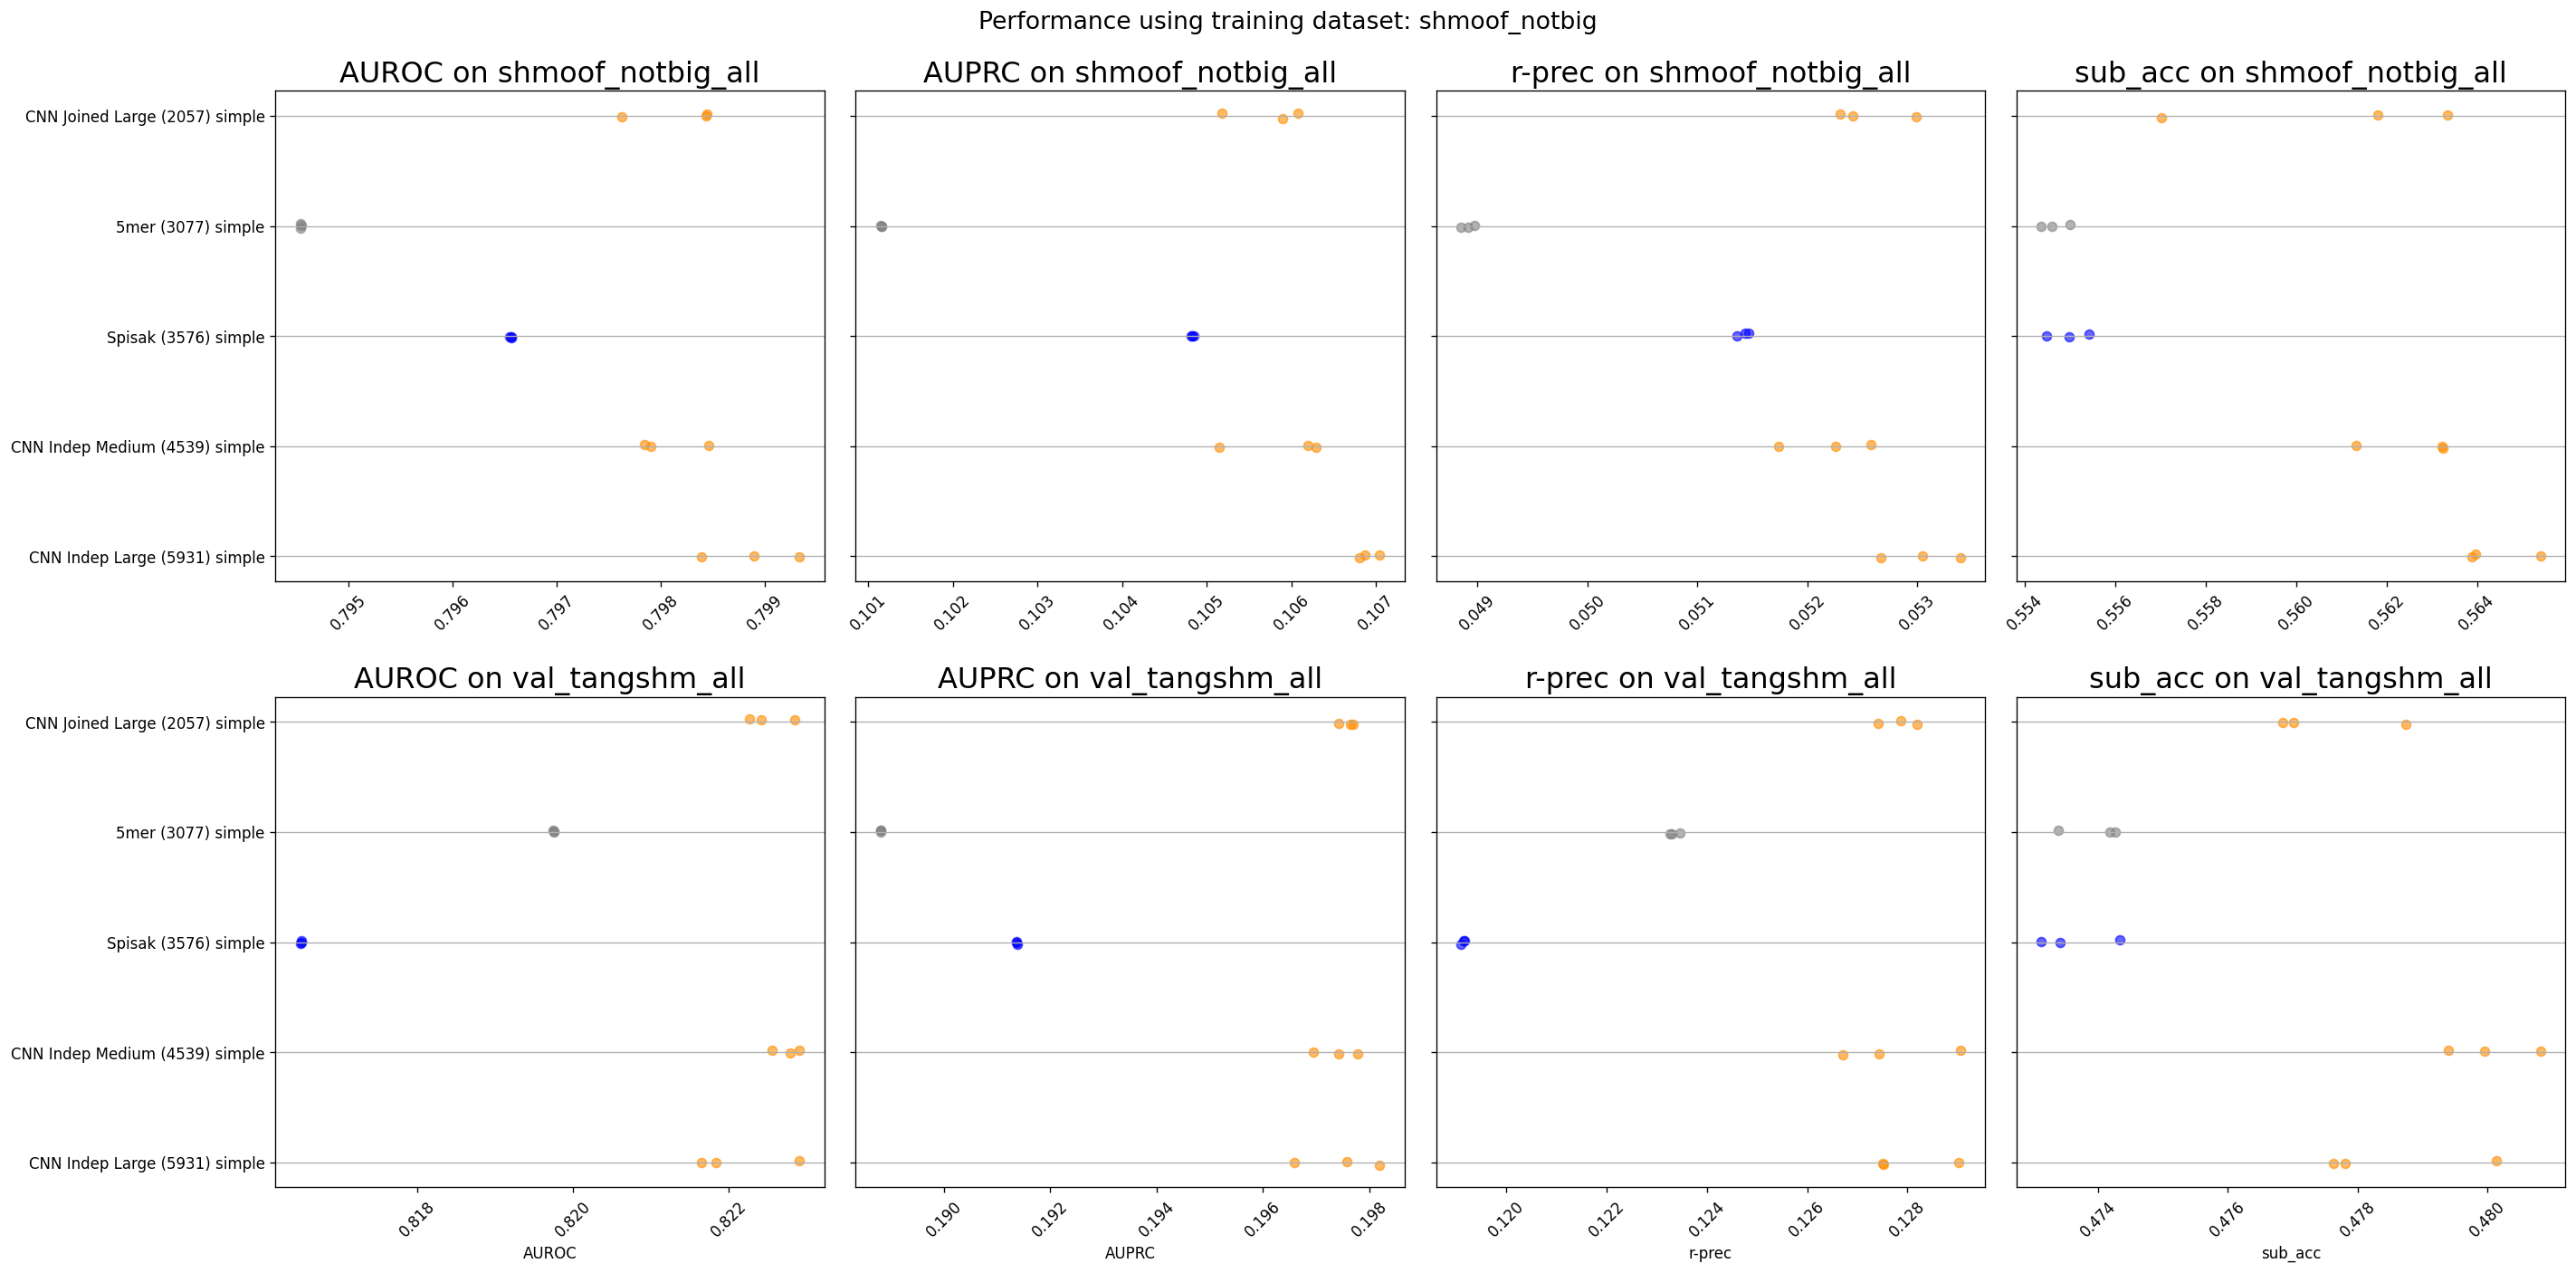

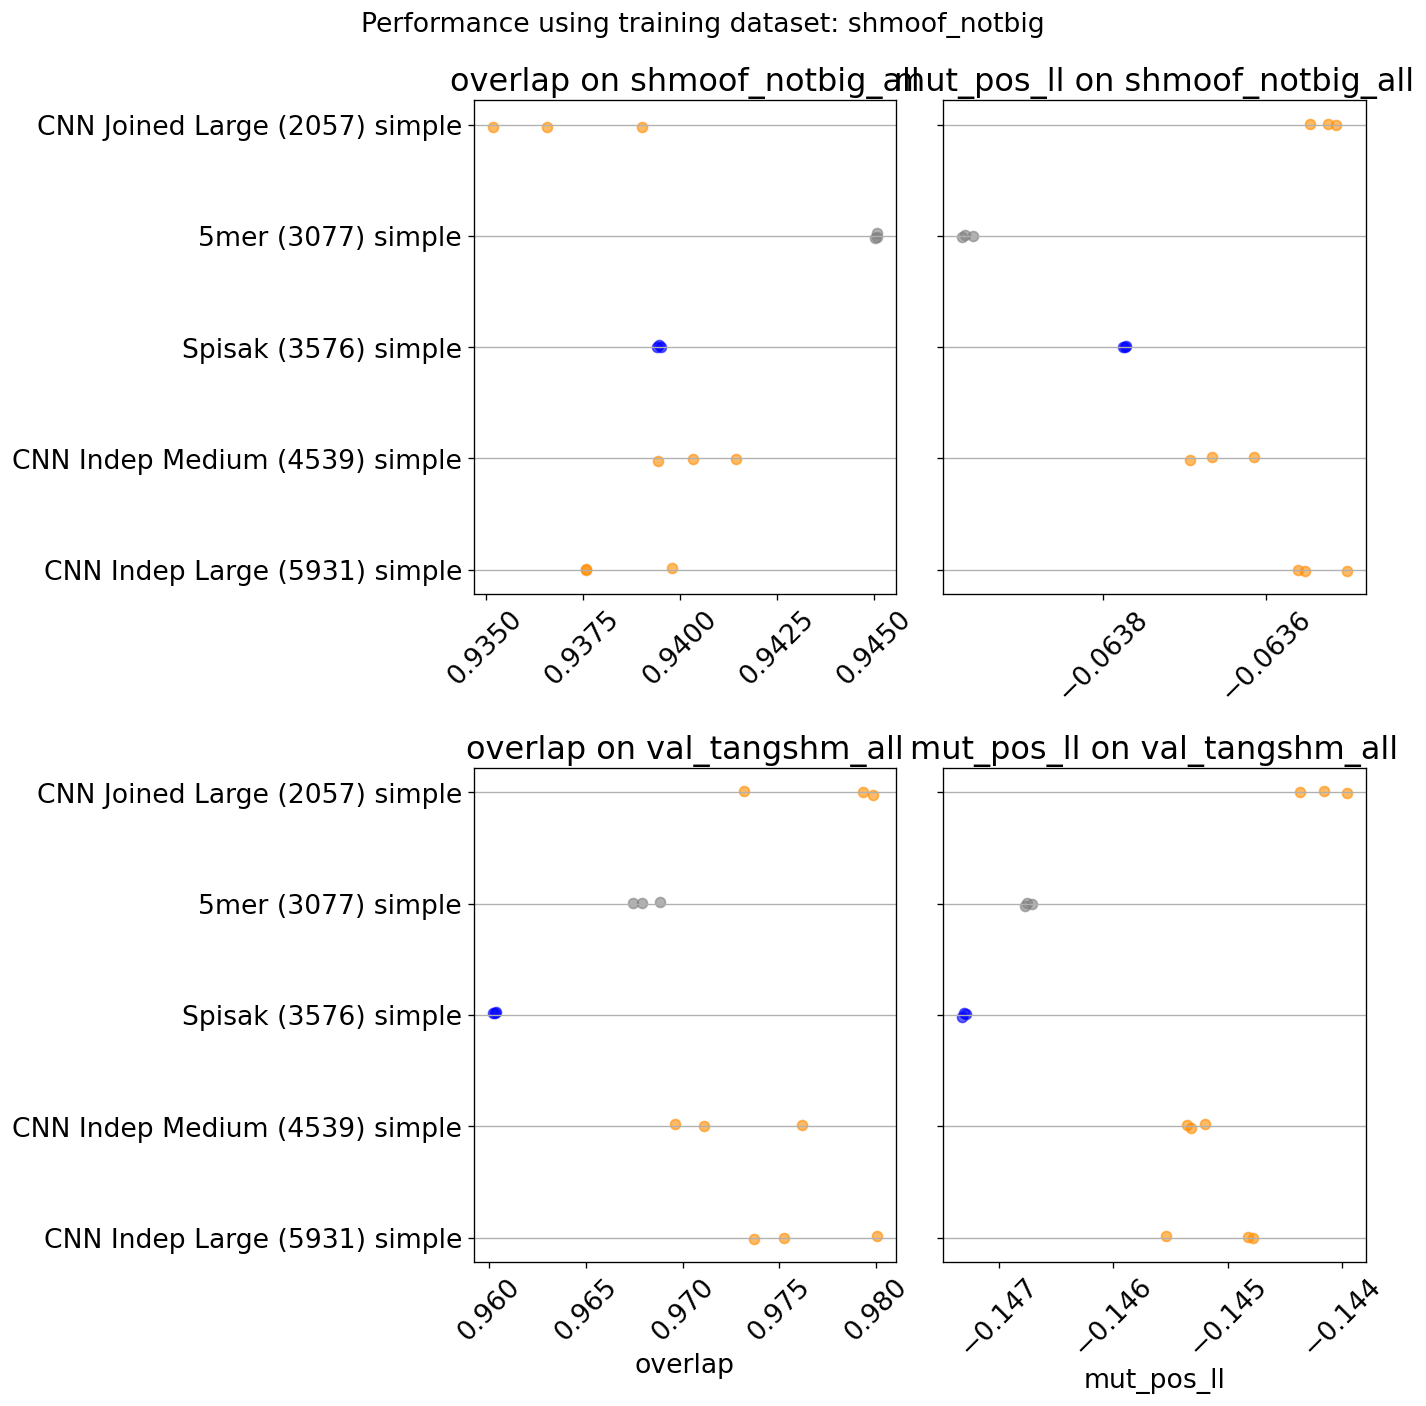

In [4]:
def plot_performance(df, train_dataset, test_datasets=None, filename=None, stats=None, include_reference=False, include_baseline=True):
    baseline_model = "s5f"
    reference_model = "cnn_ind_med-shmoof_small"
    df = df.copy()
    df = df[df["long_name"] != "Oracle"]
    df = df[df["model"] != "cnn_hyb_sml"]

    if train_dataset not in df['train dataset'].unique():
        raise ValueError(f"train dataset {train_dataset} not found in df")

    if stats is None:
        stats = ['AUROC', 'AUPRC', 'r-prec', 'sub_acc', 'overlap', 'mut_pos_ll']
    if test_datasets is None:
        test_datasets = df['test dataset'].unique()
    else:
        # check to make sure all test_datasets are in df
        for test_dataset in test_datasets:
            if test_dataset not in df['test dataset'].unique():
                raise ValueError(f"test dataset {test_dataset} not found in df")
    # # filter test_datasets to only include ones that end with _all
    # test_datasets = [x for x in test_datasets if x.endswith("_all")]
    unique_long_names = df['long_name'].unique()[::-1]
    name_to_y = {name: i for i, name in enumerate(unique_long_names)}

    # Setup figure parameters, transposing nrows with ncols
    nrows = len(test_datasets)
    ncols = len(stats)

    # Define the jitter range for the y-values
    jitter_strength = 0.05  # Smaller for subtler jitter

    # Loop through each training dataset to create separate figures or subplot grids
    # for train_dataset in train_datasets:
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 6 * nrows), squeeze=False, sharey=True)
    # set font size for fig
    plt.rcParams.update({'font.size': 16})
    fig.suptitle(f'Performance using training dataset: {train_dataset}', fontsize=16)

    for row_idx, test_dataset in enumerate(test_datasets):
        # Filter the DataFrame for models trained on `train_dataset` and tested on `test_dataset`
        df_filtered = df[(df['train dataset'] == train_dataset) & (df['test dataset'] == test_dataset)].copy()

        baseline_values = fixed_df.query("dataset_name == @test_dataset and crepe_basename == @baseline_model").reset_index(drop=True).iloc[0]
        reference_values = fixed_df.query("dataset_name == @test_dataset and crepe_basename == @reference_model").reset_index(drop=True).iloc[0]

        for col_idx, stat in enumerate(stats):
            if not df_filtered.empty:
                df_filtered[stat + '_relative'] = df_filtered[stat] - baseline_values[stat]
                df_filtered = df_filtered.sort_values(by="parameter_count", ascending=False)

                ax = axes[row_idx, col_idx]

                # Plot each point, adding jitter around the assigned y-value
                for i, row in df_filtered.iterrows():
                    y_pos = name_to_y[row['long_name']] + (np.random.rand() - 0.5) * jitter_strength
                    if row["model"][:3] == "cnn":
                        color = "darkorange"
                    elif row["model"] == "rsshmoof":
                        color = "blue"
                    else:
                        color = "gray"
                    ax.scatter(row[stat], y_pos, color=color, alpha=0.6)
                    print(row['long_name'])

                if include_baseline:
                    ax.axvline(x=baseline_values[stat], color='k')
                if include_reference:
                    ax.axvline(x=reference_values[stat], color='purple')

                ax.yaxis.grid(True, which='major')
                ax.set_yticks(np.arange(len(unique_long_names)))
                ax.set_yticklabels(unique_long_names)
                ax.set_title(f"{stat} on {test_dataset}")
                ax.tick_params(axis='x', rotation=45)
                if row_idx == nrows - 1:  # Only set x-labels for the bottom row
                    ax.set_xlabel(f'{stat}')
    fig.tight_layout()
    if filename is None:
        filename = f"performance_train_{train_dataset}" 
    fig.savefig(os.path.join(figures_dir, f"{filename}.svg"))

# print(df["train dataset"].unique())
# print(df["test dataset"].unique())

prediction_stats = ['AUROC', 'AUPRC', 'r-prec', 'sub_acc']
fit_stats = ['overlap', 'mut_pos_ll']

plot_performance(df, train_dataset='shmoof_notbig', stats=prediction_stats, include_baseline=False, filename="performance_train_shmoof_notbig_prediction")
plot_performance(df, train_dataset='shmoof_notbig', stats=fit_stats, include_baseline=False, filename="performance_train_shmoof_notbig_fit")
#plot_performance(df, train_dataset='shmoof_small', test_datasets=["shmoof_notbig_all","shmoof_small_all","val_tangshm_all"])
#plot_performance(df, train_dataset='shmoof_small', test_datasets=["val_syn10x25k_all"], filename="performance_train_shmoof_small_ON_syn10x25k")
#plot_performance(df, train_dataset='shmoof_small+syn10x', test_datasets=["val_tangshm_all"])

CNN Indep Large (5931) simple
CNN Indep Large (5931) simple
CNN Indep Large (5931) simple
CNN Indep Medium (4539) simple
CNN Indep Medium (4539) simple
CNN Indep Medium (4539) simple
Spisak (3576) simple
Spisak (3576) simple
Spisak (3576) simple
5mer (3077) simple
5mer (3077) simple
5mer (3077) simple
CNN Joined Large (2057) simple
CNN Joined Large (2057) simple
CNN Joined Large (2057) simple
CNN Indep Large (5931) simple
CNN Indep Large (5931) simple
CNN Indep Large (5931) simple
CNN Indep Medium (4539) simple
CNN Indep Medium (4539) simple
CNN Indep Medium (4539) simple
Spisak (3576) simple
Spisak (3576) simple
Spisak (3576) simple
5mer (3077) simple
5mer (3077) simple
5mer (3077) simple
CNN Joined Large (2057) simple
CNN Joined Large (2057) simple
CNN Joined Large (2057) simple
CNN Indep Large (5931) simple
CNN Indep Large (5931) simple
CNN Indep Large (5931) simple
CNN Indep Medium (4539) simple
CNN Indep Medium (4539) simple
CNN Indep Medium (4539) simple
Spisak (3576) simple
Spis

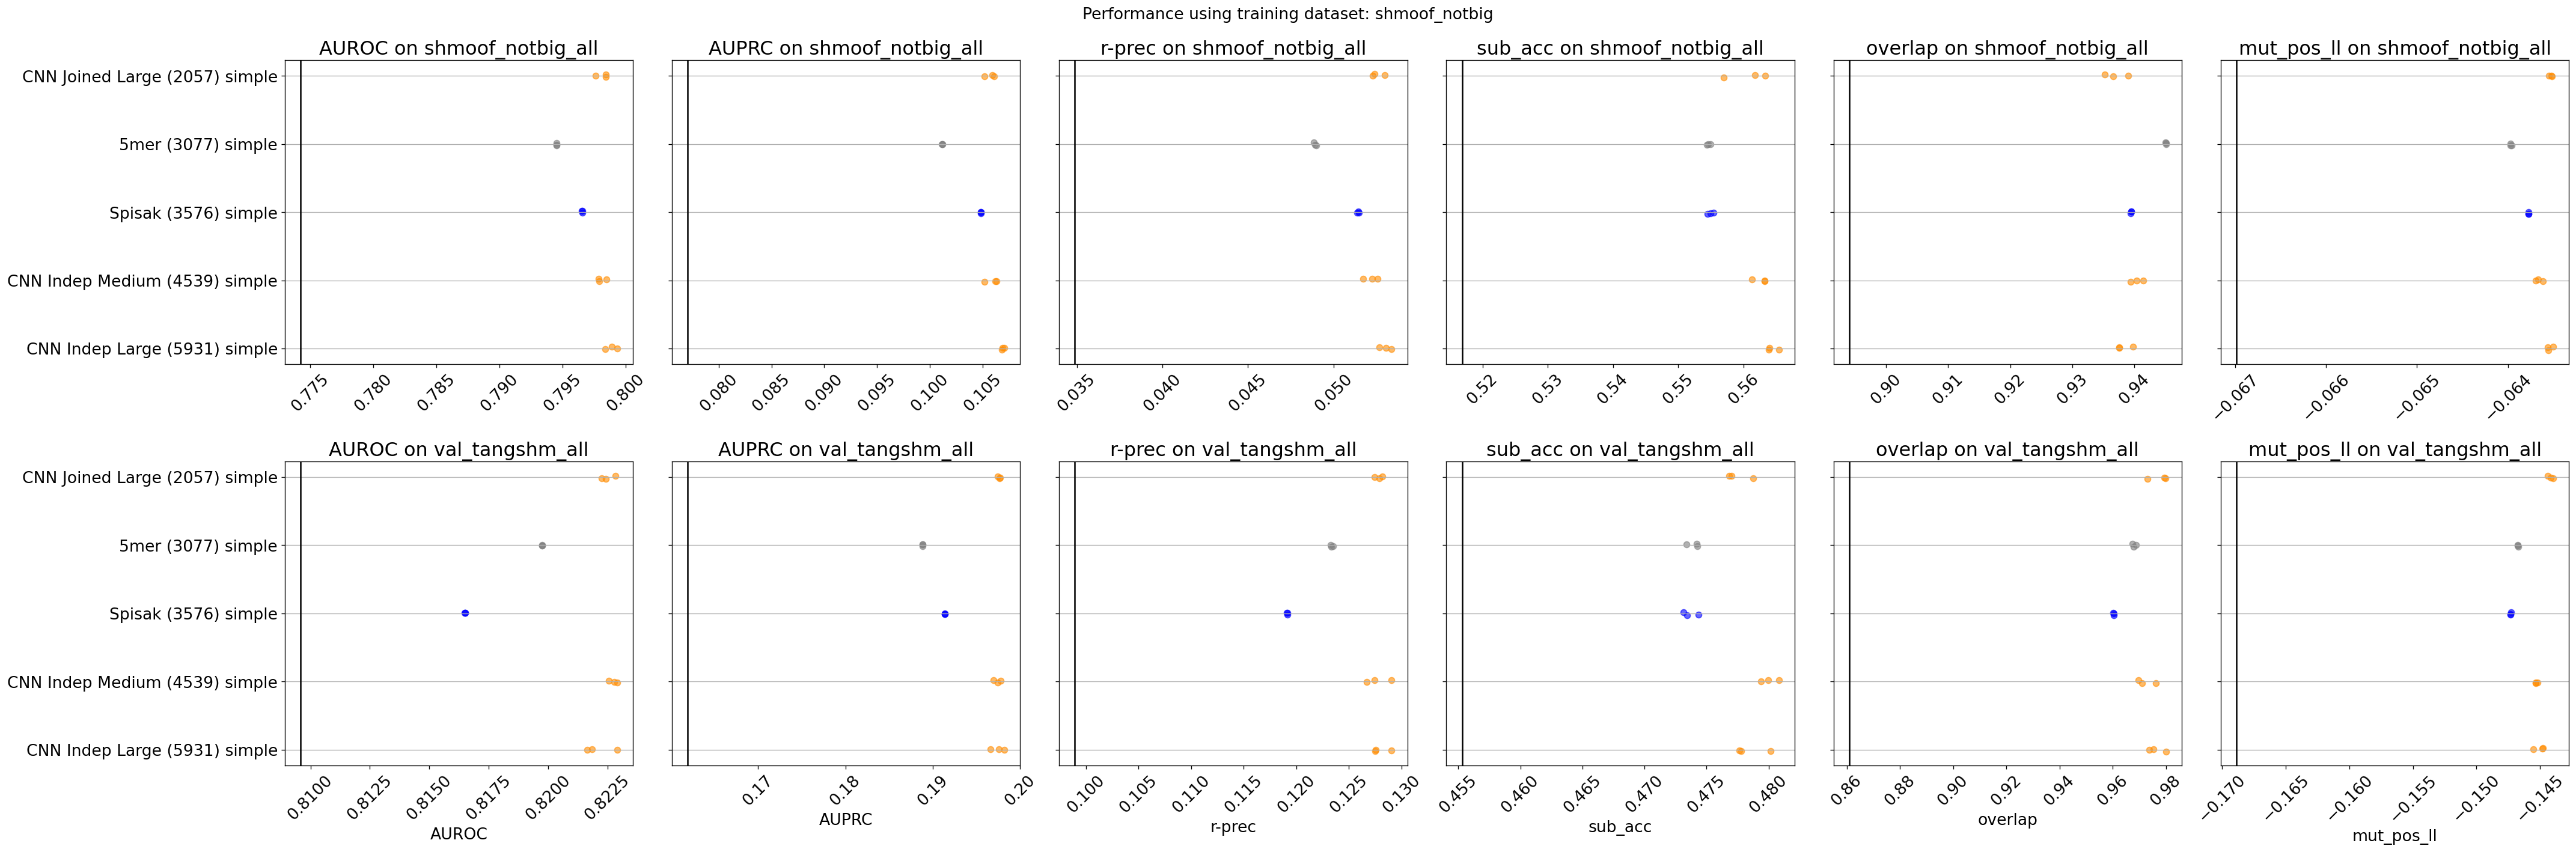

In [5]:
for train_dataset in df["train dataset"].unique():
    plot_performance(df, train_dataset=train_dataset)